In [35]:
import os
import cv2
import torch
import json
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import custom_utils.data_conversion as data_conversion
import custom_utils.depth_anything_interface as depth_anything_interface

MODEL_TYPE = "base"
ENCODER = "vitl"
DATAFILE = "/scratchdata/moving_2L"
CAMERA_JSON = "/scratchdata/gemini_2l.json"
MODEL_PATH = f"/scratchdata/depth_anything_v2_{ENCODER}.pth"
with open(CAMERA_JSON, 'r') as f:
    CAMERA_DATA = json.load(f)
FRAME_INDEX = 0
SQUARE_SIZE = 24 #mm
CHECKERBOARD = (8,6)
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
MODEL = depth_anything_interface.get_model(DEVICE, MODEL_PATH, model_type = MODEL_TYPE, encoder=ENCODER)

# Open bag file
bag_file_path = os.path.join(DATAFILE, "raw.bag")
bag = rosbag.Bag(bag_file_path)

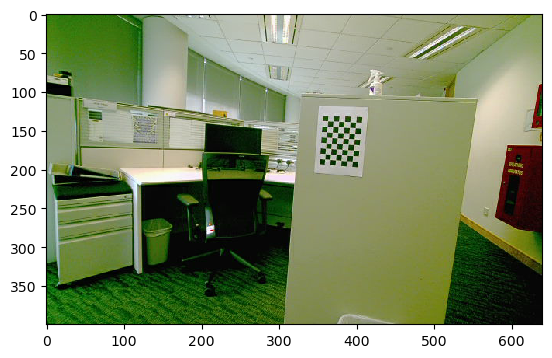

In [36]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    if wait == FRAME_INDEX:
        img = data_conversion.topic_to_image(msg)
        break
    wait += 1

plt.imshow(img)

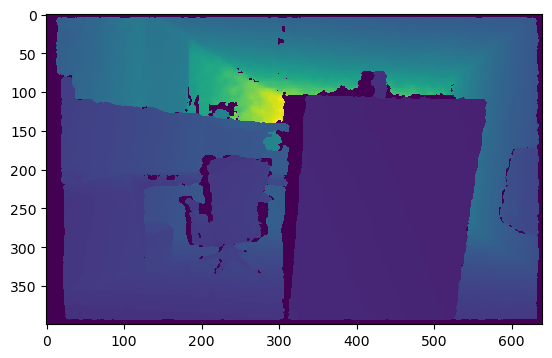

In [37]:
wait = 0

for topic, msg, t in bag.read_messages(topics=["/camera/depth/image_raw"]):
    if wait == FRAME_INDEX:
        depth = data_conversion.topic_to_depth(msg, CAMERA_DATA)
        break
    wait += 1

plt.imshow(depth)

[4.39844218e+02 5.83646821e+01 1.12640946e-01]
R2: 0.96458908164629


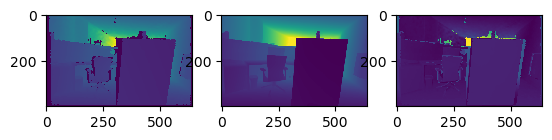

In [38]:
est_depth = MODEL.infer_image(np.array(img)) # HxW raw depth map in numpy

pred_depth, popt = depth_anything_interface.get_pred_depth(depth, est_depth, CAMERA_DATA, depth_anything_interface.estimated_depth_model, verbose=True)

fig, axs = plt.subplots(1, 3)

depth_normalised = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))
pred_normalised = (pred_depth - np.min(pred_depth)) / (np.max(pred_depth) - np.min(pred_depth))

axs[0].imshow(depth_normalised)
axs[1].imshow(pred_normalised)
diff = abs(depth_normalised - pred_normalised)
axs[2].imshow(diff)

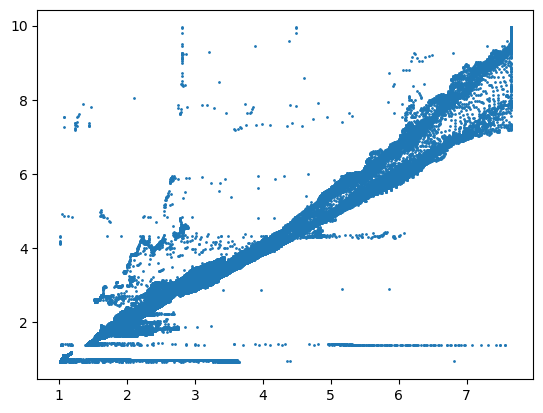

In [39]:
depth_flatten = depth.flatten()
est_depth_flatten = est_depth.flatten()
est_depth_flatten = est_depth_flatten[depth_flatten!=CAMERA_DATA["min_range"]]
depth_flatten = depth_flatten[depth_flatten!=CAMERA_DATA["min_range"]]
#est_depth_flatten = est_depth_flatten[depth_flatten>=CAMERA_DATA["min_acc_range"]]
#depth_flatten = depth_flatten[depth_flatten>=CAMERA_DATA["min_acc_range"]]
#est_depth_flatten = est_depth_flatten[depth_flatten<=CAMERA_DATA["max_acc_range"]]
#depth_flatten = depth_flatten[depth_flatten<=CAMERA_DATA["max_acc_range"]]

plt.scatter(depth_anything_interface.estimated_depth_model(est_depth_flatten, *popt), depth_flatten, s=1)

In [40]:
for topic, msg, t in bag.read_messages(topics=["/camera/color/camera_info"]):
    print(msg)
    D = np.array(msg.D)
    K = np.array(msg.K).reshape((3, 3))
    P = np.array(msg.P).reshape((3, 4))
    R = np.array(msg.R).reshape((3, 3))
    height = msg.height
    width = msg.width
    distortion_model = msg.distortion_model
    break

header: 
  seq: 847
  stamp: 
    secs: 1724209037
    nsecs: 875497984
  frame_id: "camera_color_optical_frame"
height: 400
width: 640
distortion_model: "rational_polynomial"
D: [-1.0653736591339111, 0.47793787717819214, -0.000639380537904799, 0.0004882288631051779, -0.02852124534547329, -1.0467253923416138, 0.4518430233001709, -0.018296383321285248]
K: [306.4570007324219, 0.0, 319.01312255859375, 0.0, 306.4668884277344, 197.51637268066406, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [306.4570007324219, 0.0, 319.01312255859375, 0.0, 0.0, 306.4668884277344, 197.51637268066406, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 0
binning_y: 0
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: False


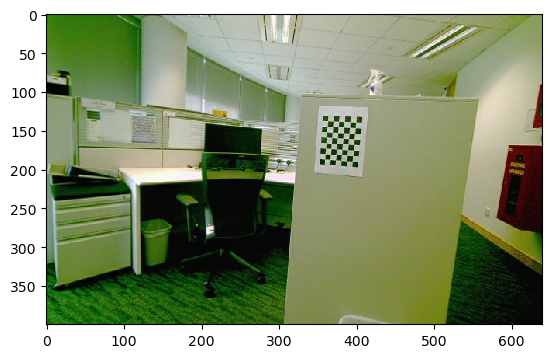

In [41]:
# Undistort image
img_undistorted = cv2.undistort(img, K, D, P)

plt.imshow(img_undistorted)

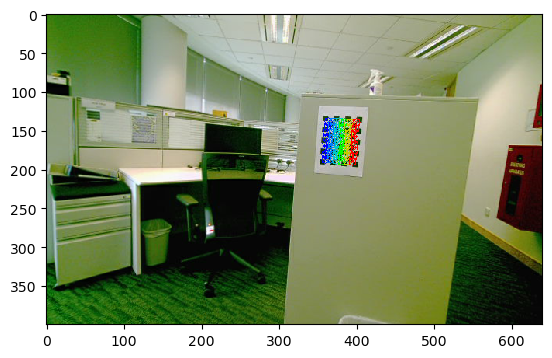

In [42]:
#Estimate distance of checkerboard
# Load camera matrix
ret, corners = cv2.findChessboardCorners(
    img_undistorted, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH)
if ret:
    fnl = cv2.drawChessboardCorners(np.float32(img_undistorted/255.0), CHECKERBOARD, corners, ret)
    plt.imshow(fnl)
else:
    print("No Checkerboard Found")
    plt.imshow(res)


In [43]:
# Prepare the object points (3D points in real world space)
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= SQUARE_SIZE  # Scale by the size of the squares

ret, rvec, tvec = cv2.solvePnP(objp, corners, K, D)
rotation_matrix, _ = cv2.Rodrigues(rvec)
transformation_matrix = np.hstack((rotation_matrix, tvec))
transformation_matrix = np.vstack((transformation_matrix, [0, 0, 0, 1]))

In [44]:
# Find norm distance between objp and tvec

camera_estimated_depth = []
for p in objp:
    camera_estimated_depth.append(np.linalg.norm(p - tvec.reshape(3)))

camera_estimated_depth = np.array(camera_estimated_depth) / 1000

print(camera_estimated_depth)

[1.06944169 1.06654812 1.06418807 1.06236511 1.06108199 1.06034068
 1.06014231 1.0604872  1.07045762 1.0675668  1.06520901 1.0633878
 1.06210592 1.06136532 1.06116715 1.0615117  1.07201002 1.06912341
 1.06676906 1.06495051 1.06367051 1.06293101 1.06273313 1.06307717
 1.07409659 1.07121559 1.06886585 1.06705088 1.0657734  1.06503536
 1.06483787 1.06518123 1.0767142  1.07384023 1.07149624 1.06968573
 1.06841141 1.06767519 1.06747818 1.0678207  1.079859   1.07699342
 1.07465631 1.07285113 1.07158057 1.07084653 1.07065011 1.07099161]


In [45]:
original_depth = data_conversion.interpolate_depth(depth,corners.reshape(-1, 2))
print(original_depth)

[1.07521467 1.07153387 1.06804703 1.06710354 1.06109522 1.05793033
 1.05445835 1.05147379 1.06704262 1.06369159 1.06116589 1.05877365
 1.05487852 1.04945621 1.04701709 1.0452222  1.06001388 1.05850435
 1.05380585 1.04857404 1.0469644  1.044      1.04170151 1.04
 1.05415857 1.05123575 1.04742954 1.044      1.04272186 1.04
 1.03771179 1.03344287 1.04706548 1.04442187 1.04051773 1.03998489
 1.03554993 1.03278888 1.03049736 1.02790508 1.04235093 1.04002058
 1.03618757 1.03317526 1.02834034 1.027      1.02365268 1.02152018]


Mean error:  0.021367283730583508
Max error:  0.049471429172095016
Standard deviation:  0.013797947380083778


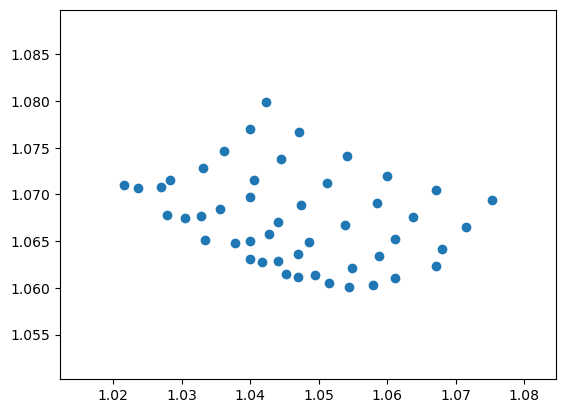

In [46]:
error = np.abs(original_depth - camera_estimated_depth)
print("Mean error: ", np.mean(error))
print("Max error: ", np.max(error))
print("Standard deviation: ", np.std(error))

plt.scatter(original_depth, camera_estimated_depth)

In [47]:
est_depth = data_conversion.interpolate_depth(pred_depth,corners.reshape(-1, 2))
print(est_depth)

[1.07487774 1.07213826 1.07012916 1.06854498 1.06710931 1.06539382
 1.06413472 1.06308905 1.07113184 1.06868571 1.06618436 1.06431606
 1.06256891 1.06077154 1.05941128 1.05810912 1.06815324 1.06536421
 1.0631889  1.06064646 1.0591026  1.05710681 1.05530115 1.05412202
 1.06478652 1.06249608 1.05975105 1.05756069 1.05584673 1.05428383
 1.05200123 1.05036232 1.06159494 1.05900048 1.05661582 1.05436349
 1.05279562 1.05068846 1.04878326 1.04670619 1.05866539 1.05646077
 1.05413138 1.05195371 1.05024492 1.04810519 1.04560111 1.04391047]


Mean error:  0.010206478215095766
Max error:  0.02708113628202602
Standard deviation:  0.007523513369653397


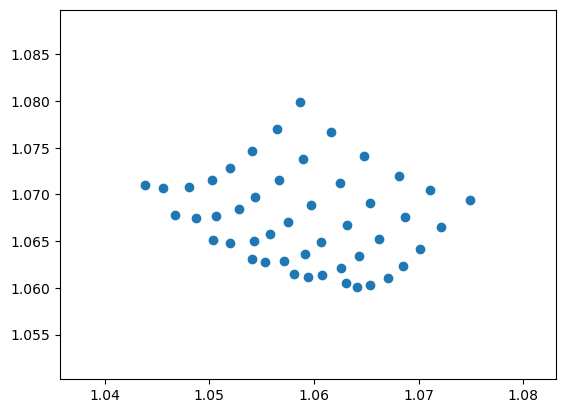

In [48]:
error = np.abs(est_depth - camera_estimated_depth)
print("Mean error: ", np.mean(error))
print("Max error: ", np.max(error))
print("Standard deviation: ", np.std(error))

plt.scatter(est_depth, camera_estimated_depth)